In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Exploratory Data Analysis for Renewable Energy Sources (RES) Generation
This script performs EDA on the processed RES generation data for the Italian energy market.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
from pathlib import Path
import warnings



In [21]:


# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)

# Define paths - relative to script location
BASE_DIR = Path(os.getcwd()).parent
DATA_DIR = BASE_DIR / 'data/final/Italy'
IMAGES_DIR = BASE_DIR / 'outputs/images'
PROCESSED_DIR = BASE_DIR / 'data/processed/Italy'

# Create directories if they don't exist
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)


print("Train/test data saved to:", DATA_DIR)


Train/test data saved to: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/final/Italy


In [22]:
def load_data():
    """Load the processed RES generation data"""
    print("Loading RES generation data...")
    file_path = DATA_DIR / 'res_generation2015_2024_merged.csv'
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    # Ensure consistent column naming
    if 'Total_RES_Generation_MW' in df.columns:
        df.rename(columns={'Total_RES_Generation_MW': 'total_res_mw'}, inplace=True)
    elif 'RES' in df.columns:
        df.rename(columns={'RES': 'total_res_mw'}, inplace=True)
    
    print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

def display_basic_stats(df):
    """Display basic statistics of the data"""
    print("\nBasic Statistics:")
    print(df.describe())
    
    print("\nMissing Values:")
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.any() > 0 else "No missing values")
    
    print("\nFirst few rows:")
    print(df.head())

def time_series_analysis(df):
    """Perform time series analysis"""
    print("\nPerforming time series analysis...")
    
    # Ensure date is set as index for time series operations
    if 'date' in df.columns:
        df.set_index('date', inplace=True)
    
    # Resample to monthly for better visualization
    monthly_res = df['total_res_mw'].resample('M').mean()
    
    # Plot time series
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['total_res_mw'], linewidth=1, alpha=0.7, label='Daily RES Generation')
    plt.plot(monthly_res.index, monthly_res, linewidth=2, color='red', label='Monthly Average RES Generation')
    plt.title('RES Generation Time Series (2015-2024)')
    plt.ylabel('Generation (MW)')
    plt.xlabel('Date')
    plt.grid(True)
    plt.legend()
    plt.savefig(IMAGES_DIR / 'res_time_series.png', bbox_inches='tight')
    
    # Seasonal decomposition
    print("Performing seasonal decomposition...")
    decomposition = seasonal_decompose(df['total_res_mw'], model='additive', period=365)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 16))
    decomposition.observed.plot(ax=axes[0], title='Observed')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'res_decomposition.png', bbox_inches='tight')
    
    # Stationarity tests
    print("\nStationarity Tests:")
    adf_result = adfuller(df['total_res_mw'].dropna())
    print(f"ADF Test: p-value = {adf_result[1]:.4f}")
    print(f"ADF Critical Values: {adf_result[4]}")
    
    kpss_result = kpss(df['total_res_mw'].dropna())
    print(f"KPSS Test: p-value = {kpss_result[1]:.4f}")
    print(f"KPSS Critical Values: {kpss_result[3]}")
    
    # ACF and PACF plots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    plot_acf(df['total_res_mw'].dropna(), lags=50, ax=axes[0])
    plot_pacf(df['total_res_mw'].dropna(), lags=50, ax=axes[1])
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'res_acf_pacf.png', bbox_inches='tight')

def correlation_analysis(df):
    """Perform correlation analysis"""
    print("\nPerforming correlation analysis...")
    
    # Create time-based features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    
    # Calculate correlation between RES generation and time features
    time_features = ['year', 'month', 'day', 'dayofweek', 'quarter', 'dayofyear', 'weekofyear']
    correlations = df[time_features + ['total_res_mw']].corr()['total_res_mw'].drop('total_res_mw')
    
    # Plot correlation
    plt.figure(figsize=(12, 6))
    correlations.sort_values().plot(kind='bar')
    plt.title('Correlation of Time Features with RES Generation')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'res_time_correlation.png', bbox_inches='tight')
    
    # Monthly and daily patterns
    monthly_avg = df.groupby('month')['total_res_mw'].mean()
    daily_avg = df.groupby('dayofweek')['total_res_mw'].mean()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    monthly_avg.plot(kind='bar', ax=axes[0])
    axes[0].set_title('Average RES Generation by Month')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Average Generation (MW)')
    axes[0].grid(True)
    
    daily_avg.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Average RES Generation by Day of Week')
    axes[1].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
    axes[1].set_ylabel('Average Generation (MW)')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'res_patterns.png', bbox_inches='tight')
    
    return df

def feature_engineering(df):
    """Create features for modeling"""
    print("\nPerforming feature engineering...")
    
    # Create lag features
    df['total_res_mw_lag1'] = df['total_res_mw'].shift(1)
    df['total_res_mw_lag7'] = df['total_res_mw'].shift(7)
    df['total_res_mw_lag30'] = df['total_res_mw'].shift(30)
    
    # Create rolling window features
    df['total_res_mw_rolling_7d_mean'] = df['total_res_mw'].rolling(window=7).mean()
    df['total_res_mw_rolling_30d_mean'] = df['total_res_mw'].rolling(window=30).mean()
    df['total_res_mw_rolling_7d_std'] = df['total_res_mw'].rolling(window=7).std()
    df['total_res_mw_rolling_30d_std'] = df['total_res_mw'].rolling(window=30).std()
    
    # Create year-over-year features
    df['total_res_mw_yoy_diff'] = df['total_res_mw'] - df['total_res_mw'].shift(365)
    df['total_res_mw_yoy_ratio'] = df['total_res_mw'] / df['total_res_mw'].shift(365)
    
    # Plot some of the engineered features
    plt.figure(figsize=(14, 7))
    plt.plot(df.index[-365:], df['total_res_mw'][-365:], label='RES Generation')
    plt.plot(df.index[-365:], df['total_res_mw_rolling_7d_mean'][-365:], label='7-day MA')
    plt.plot(df.index[-365:], df['total_res_mw_rolling_30d_mean'][-365:], label='30-day MA')
    plt.title('RES Generation and Rolling Averages (Last Year)')
    plt.ylabel('Generation (MW)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.savefig(IMAGES_DIR / 'res_rolling_features.png', bbox_inches='tight')
    
    # Correlation matrix of engineered features
    feature_cols = ['total_res_mw', 'total_res_mw_lag1', 'total_res_mw_lag7', 'total_res_mw_lag30', 
                   'total_res_mw_rolling_7d_mean', 'total_res_mw_rolling_30d_mean',
                   'total_res_mw_rolling_7d_std', 'total_res_mw_rolling_30d_std']
    
    corr_matrix = df[feature_cols].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
                square=True, linewidths=0.5)
    plt.title('Correlation Matrix of Engineered Features')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'res_feature_correlation.png', bbox_inches='tight')
    
    return df

def prepare_train_test_split(df):
    """Prepare train/test split for modeling"""
    print("\nPreparing train/test split...")
    
    # Drop rows with NaN values created by lag features
    df_clean = df.dropna()
    
    # Use data until 2022 for training
    train_end_date = '2022-12-31'
    
    train_df = df_clean[df_clean.index <= train_end_date].copy()
    test_df = df_clean[df_clean.index > train_end_date].copy()
    
    print(f"Training data: {train_df.shape[0]} rows ({train_df.index.min()} to {train_df.index.max()})")
    print(f"Testing data: {test_df.shape[0]} rows ({test_df.index.min()} to {test_df.index.max()})")
    
    # Save the train/test split
    train_df.to_csv(DATA_DIR / 'res_train_data.csv')
    test_df.to_csv(DATA_DIR / 'res_test_data.csv')
    
    # Plot train/test split
    plt.figure(figsize=(14, 7))
    plt.plot(train_df.index, train_df['total_res_mw'], label='Training Data')
    plt.plot(test_df.index, test_df['total_res_mw'], label='Testing Data', color='red')
    plt.title('Train/Test Split for RES Generation Data')
    plt.ylabel('Generation (MW)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.savefig(IMAGES_DIR / 'res_train_test_split.png', bbox_inches='tight')
    
    return train_df, test_df



Starting Exploratory Data Analysis for RES Generation...
Loading RES generation data...
Data loaded: 3653 rows, 12 columns

Basic Statistics:
                      date  total_res_mw     solar_mw      wind_mw  \
count                 3653   3653.000000  3653.000000  3653.000000   
mean   2020-01-01 00:00:00  10135.069299  2369.606529  2180.882762   
min    2015-01-01 00:00:00      0.000000     0.000000     0.000000   
25%    2017-07-02 00:00:00   8410.083333  1424.166667   958.625000   
50%    2020-01-01 00:00:00  10086.166667  2383.416667  1831.500000   
75%    2022-07-02 00:00:00  11833.250000  3187.625000  3075.833333   
max    2024-12-31 00:00:00  19165.708333  7183.416667  7405.041667   
std                    NaN   2417.412436  1094.302837  1490.182970   

          hydro_mw   biomass_mw  geothermal_mw         year        month  \
count  3653.000000  3653.000000    3653.000000  3653.000000  3653.000000   
mean   4457.173367   493.473936     633.932704  2019.500411     6.522310   

/var/folders/4y/dxs3znt16fgcsl556_td55sh0000gn/T/ipykernel_91694/2718826095.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_res = df['total_res_mw'].resample('M').mean()



Stationarity Tests:
ADF Test: p-value = 0.0003
ADF Critical Values: {'1%': -3.4321522387754775, '5%': -2.862336328589075, '10%': -2.567193897993964}
KPSS Test: p-value = 0.0100
KPSS Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/4y/dxs3znt16fgcsl556_td55sh0000gn/T/ipykernel_91694/2718826095.py:69: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['total_res_mw'].dropna())



Performing correlation analysis...

Performing feature engineering...

Preparing train/test split...
Training data: 2557 rows (2016-01-01 00:00:00 to 2022-12-31 00:00:00)
Testing data: 731 rows (2023-01-01 00:00:00 to 2024-12-31 00:00:00)

EDA completed. Visualizations saved to: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/outputs/images


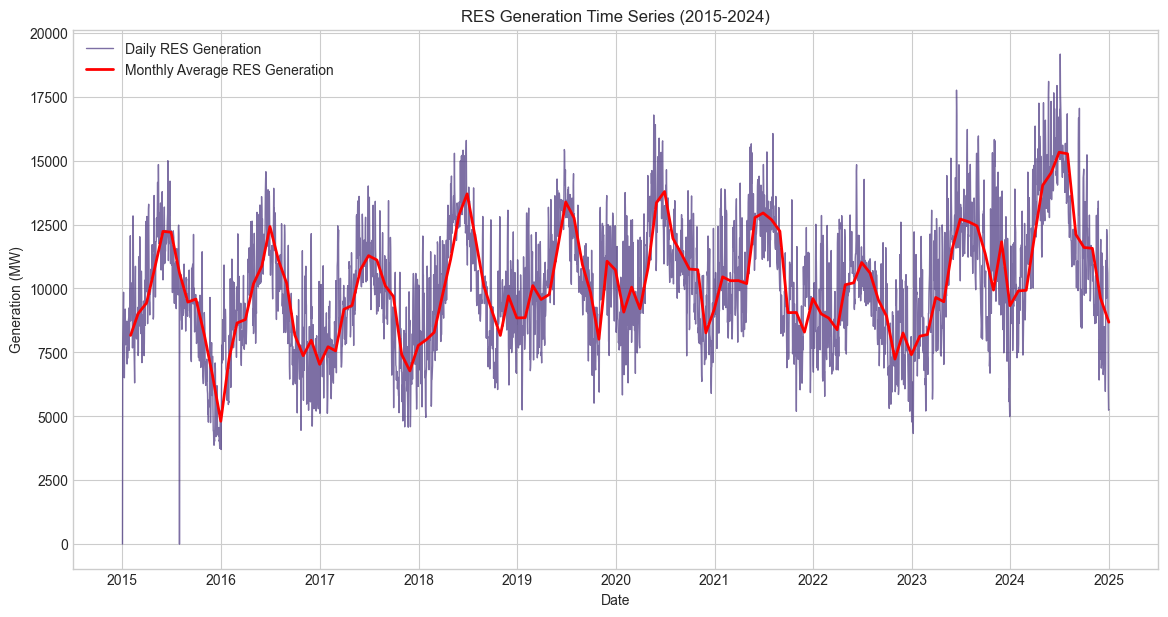

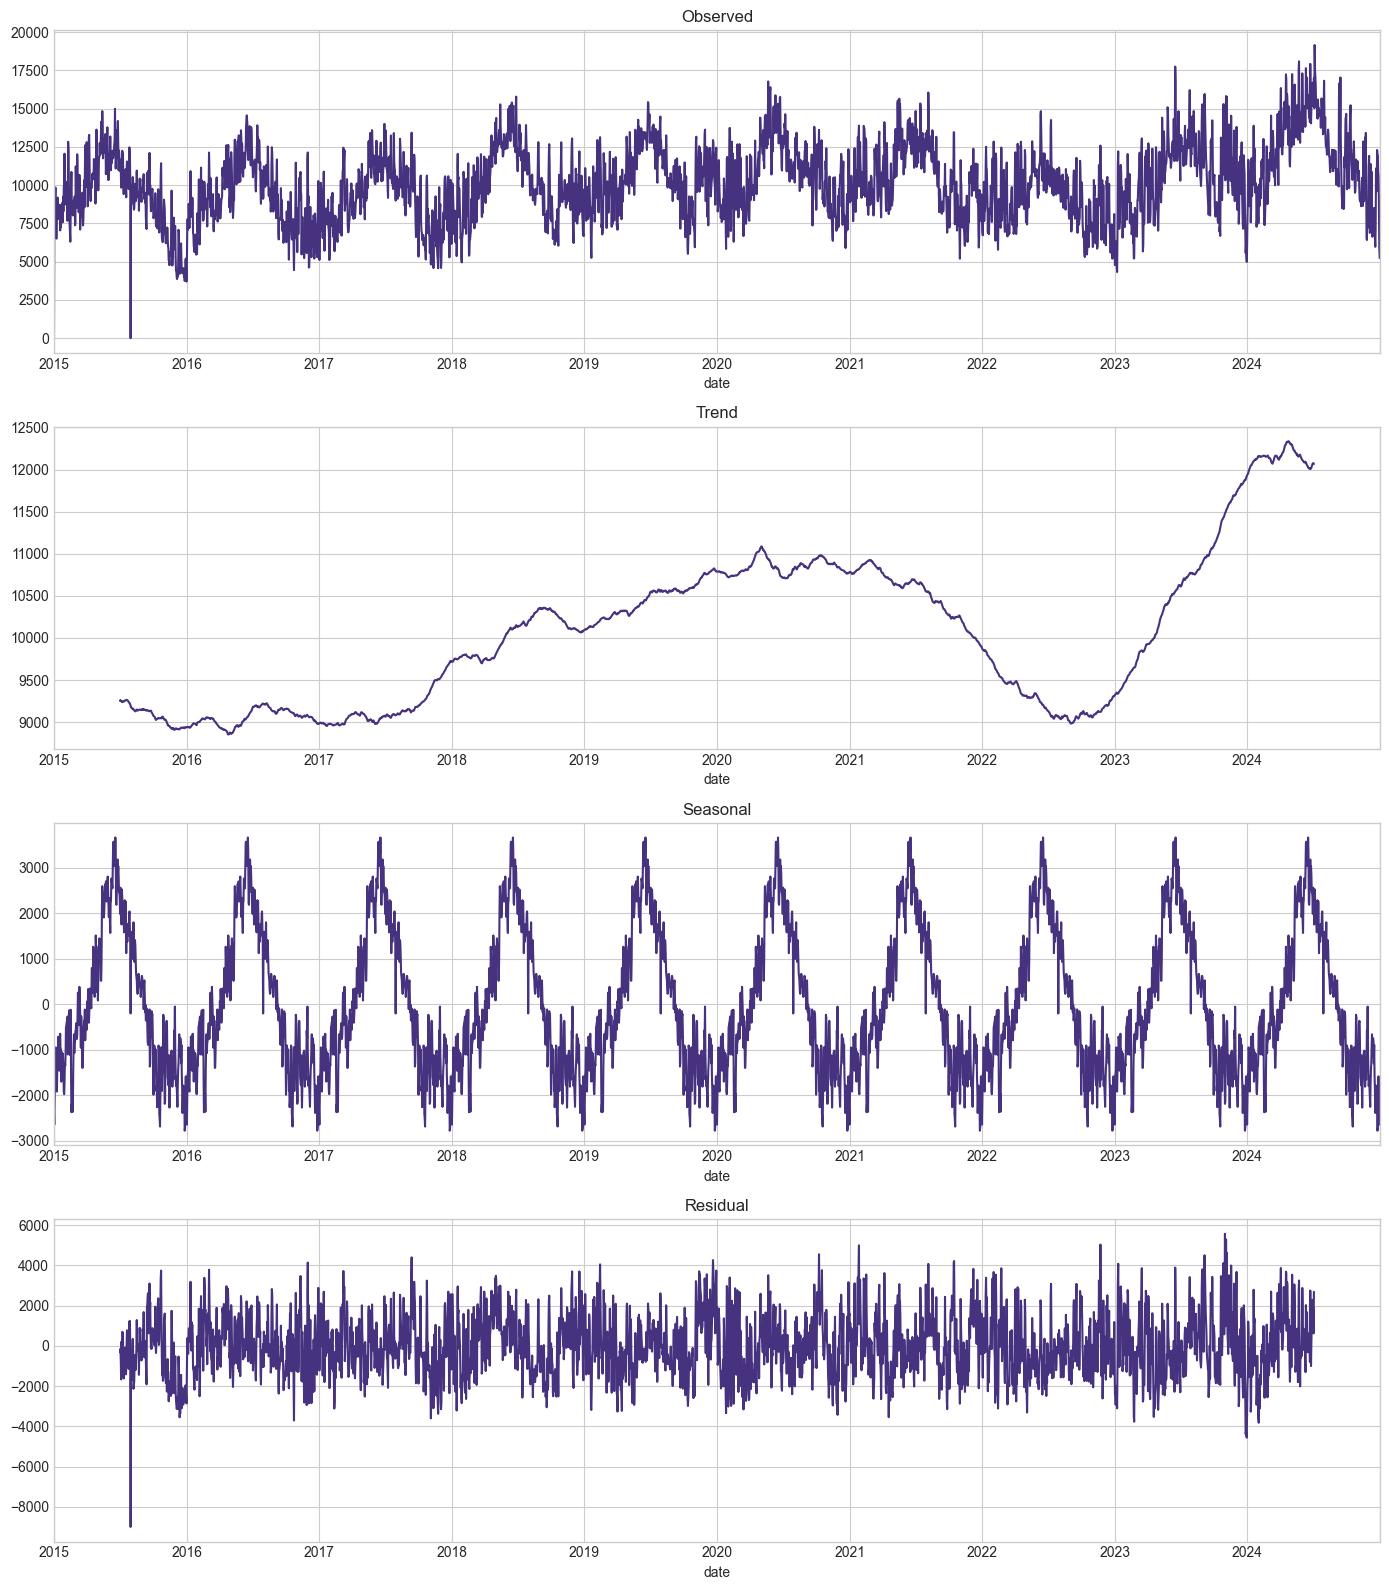

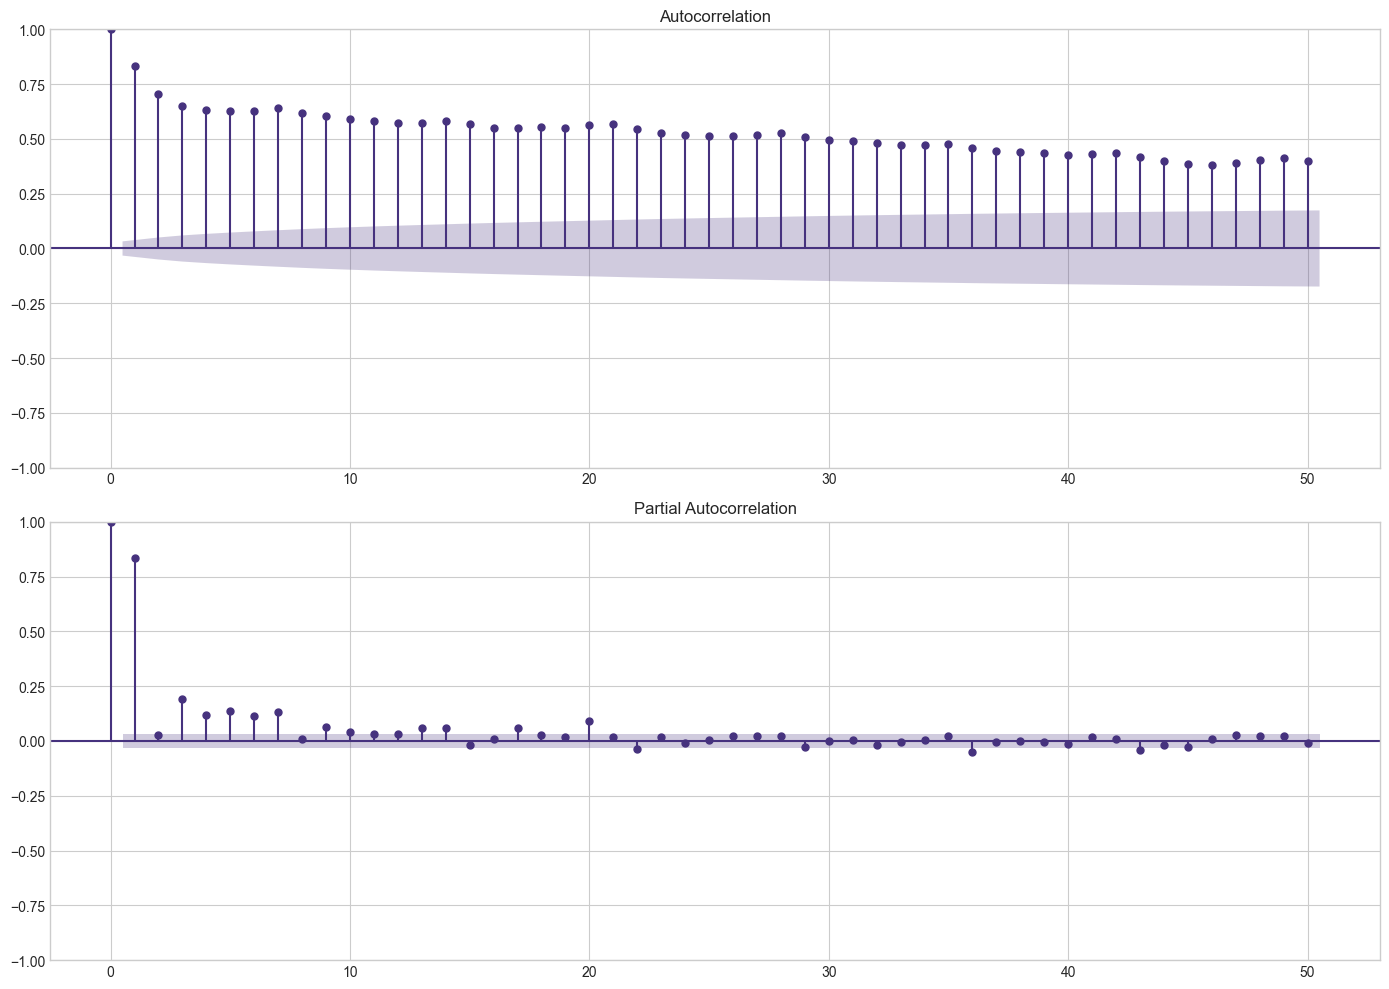

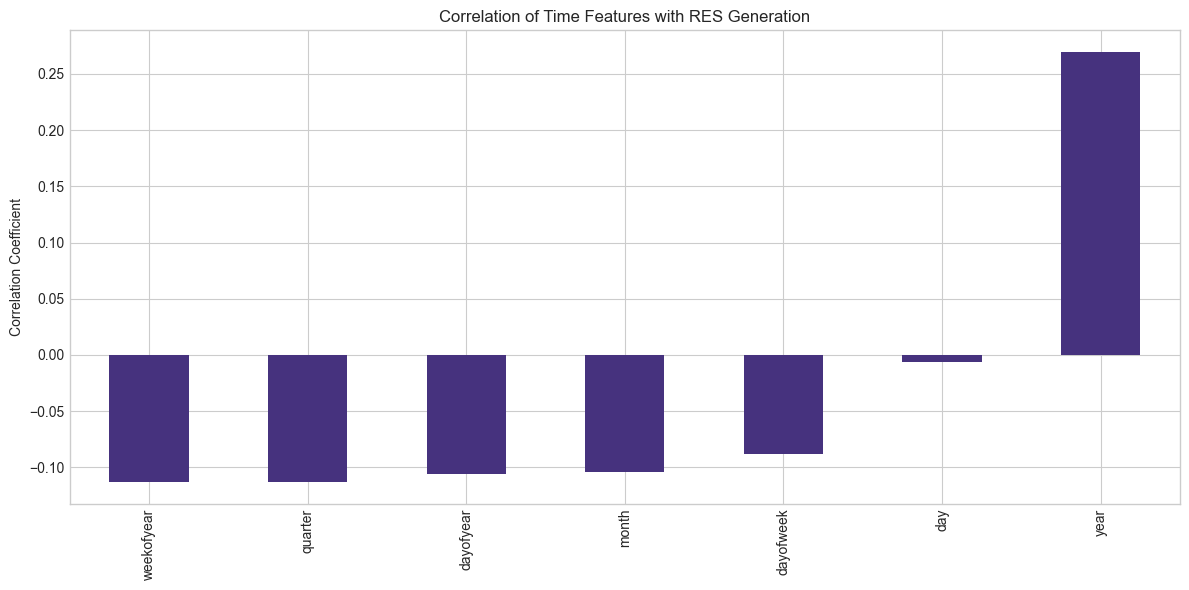

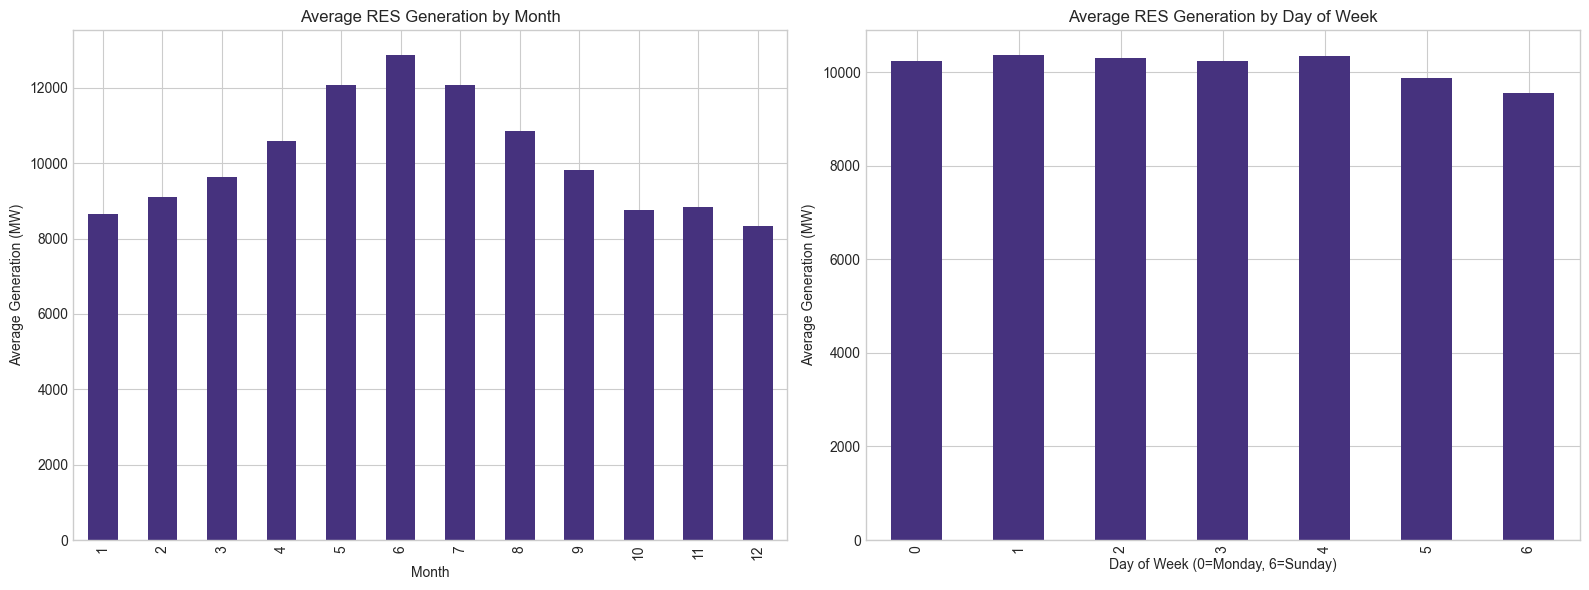

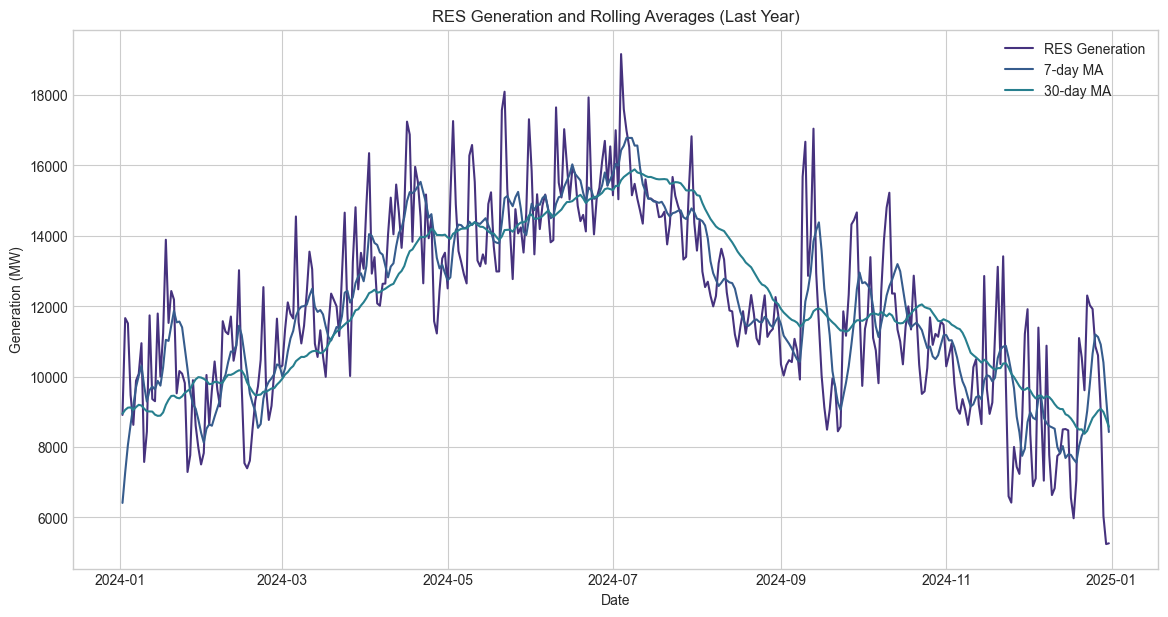

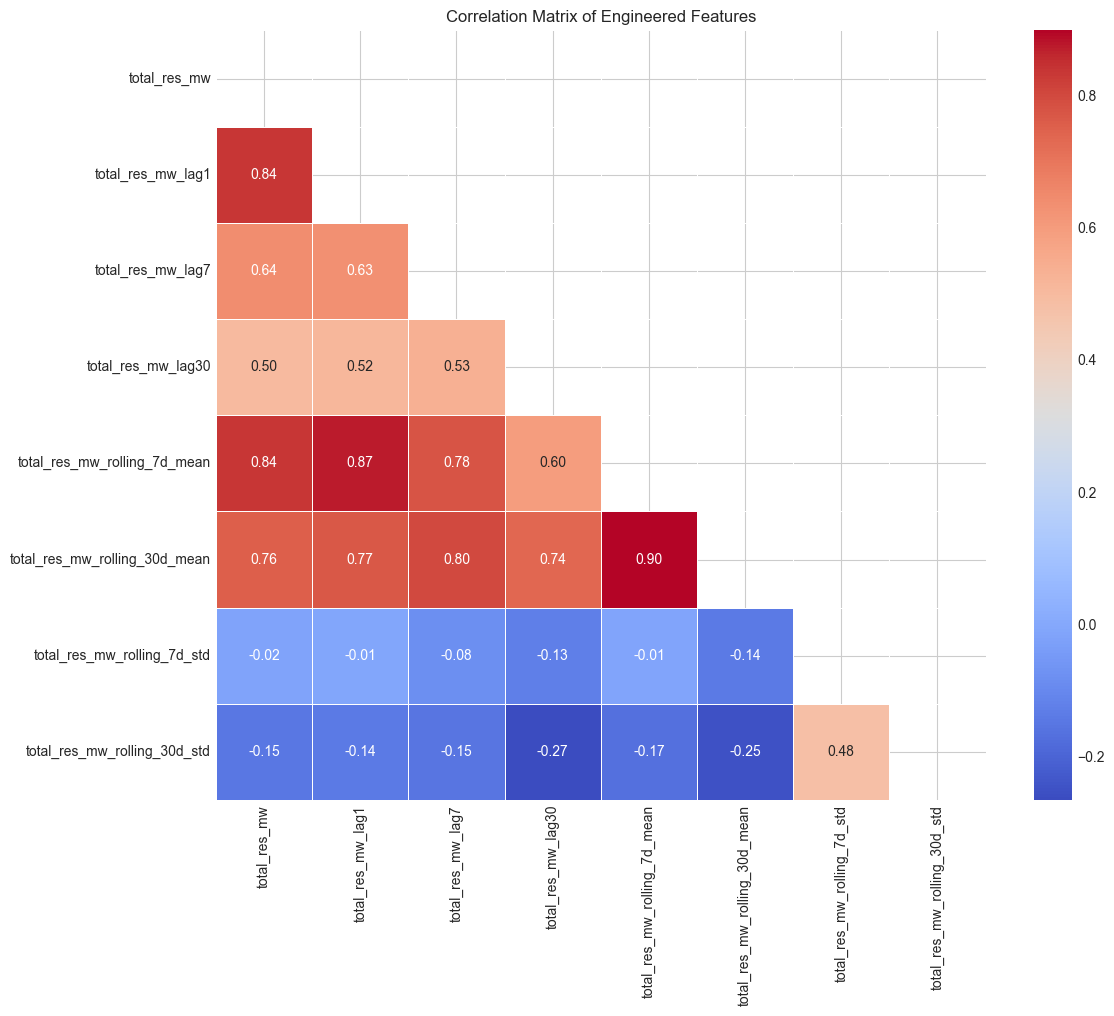

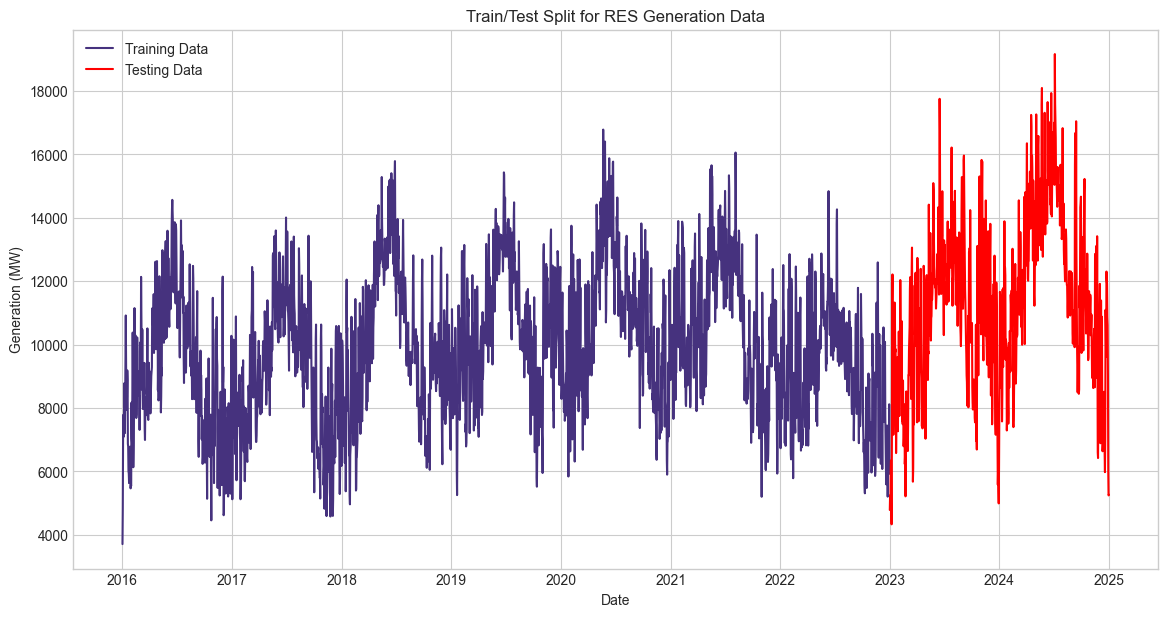

In [23]:
"""Main function to run the EDA process"""
print("Starting Exploratory Data Analysis for RES Generation...")

# Load data
df = load_data()

# Display basic statistics
display_basic_stats(df)

# Perform time series analysis
time_series_analysis(df)

# Perform correlation analysis
df = correlation_analysis(df)

# Feature engineering
df = feature_engineering(df)

# Prepare train/test split
train_df, test_df = prepare_train_test_split(df)

print("\nEDA completed. Visualizations saved to:", IMAGES_DIR)